# Работа с S3

In [2]:
import deeplake
import numpy as np

from PIL import Image

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.2.8) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## Загрузка уже существующего DeepLake датасета

На S3 должна лежать папка именно с DeepLake датасетом

In [2]:
deeplake.load('s3://test/fer2013', creds = {
   'aws_access_key_id': 'abc', 
   'aws_secret_access_key': 'xyz', 
   #'aws_session_token': '123', # Optional
   'endpoint_url': 'http://localhost:8888'
})

DatasetHandlerError: A Deep Lake dataset does not exist at the given path (s3://test/fer2013). Check the path provided or in case you want to create a new dataset, use deeplake.empty().

Теперь корректный датасет:

In [2]:
ds = deeplake.load('s3://test/deeplake_fer/deeplake_fer', creds = {
   'aws_access_key_id': 'abc', 
   'aws_secret_access_key': 'xyz', 
   #'aws_session_token': '123', # Optional
   'endpoint_url': 'http://localhost:8888'
})

s3://test/deeplake_fer/deeplake_fer loaded successfully.


In [3]:
ds.summary()

Dataset(path='s3://test/deeplake_fer/deeplake_fer', tensors=['images', 'labels'])

 tensor      htype        shape       dtype  compression
 -------    -------      -------     -------  ------- 
 images      image     (21, 48, 48)   uint8    jpeg   
 labels   class_label    (21, 1)     uint32    None   


### Обновление и синхронизация происходят одновременно

In [6]:
ds.append({'images': deeplake.read('./fer2013/train/neutral/Training_68386.jpg'), 'labels': np.uint32(4)})

In [8]:
len(ds.images)

22

Если еще раз подгрузим из хранилища, изменения будут сохранены

In [9]:
ds = deeplake.load('s3://test/deeplake_fer/deeplake_fer', creds = {
   'aws_access_key_id': 'abc', 
   'aws_secret_access_key': 'xyz', 
   #'aws_session_token': '123', # Optional
   'endpoint_url': 'http://localhost:8888'
})

s3://test/deeplake_fer/deeplake_fer loaded successfully.


In [10]:
len(ds.images)

22

## Добавление DeepLake датасета в S3

In [ ]:
!s3cmd sync {local path to deeplake dataset}  s3://{bucket_name}/

## Обычный датасет из S3 -> DeepLake датасет в S3

In [9]:
#Создадим пустой DeepLake датасет на S3
ds = deeplake.empty('s3://test/fer2013_deeplake', creds = {
   'aws_access_key_id': 'abc', 
   'aws_secret_access_key': 'xyz', 
   #'aws_session_token': '123', # Optional
   'endpoint_url': 'http://localhost:8888'
})

In [11]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [13]:
with ds:
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpeg')
    ds.create_tensor('labels', htype = 'class_label', class_names = class_names)

    # Дополнительная информация по датасету или отдельному тензору
    ds.info.update(description = 'S3 Dataset -> DeepLake S3 dataset')
    ds.images.info.update(camera_type = 'SLR')

Можно напрямую считать из S3 данные, которые мы хотим добавить в DeepLake датасет

In [15]:
with ds:
    ds.images.append(deeplake.read('s3://test/fer2013/train/surprise/Training_8796.jpg', creds = {
   'aws_access_key_id': 'abc', 
   'aws_secret_access_key': 'xyz', 
   #'aws_session_token': '123', # Optional
   'endpoint_url': 'http://localhost:8888'
}))

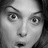

In [16]:
Image.fromarray(ds.images[0].numpy())

In [18]:
ds.labels.append(np.uint32(5))

Пример полного парсинга датасета:

In [19]:
!pip3 install boto3

In [41]:
len(ds)

1

In [20]:
import boto3

In [44]:
#Итерация по именам файлов в S3

BUCKET = 'test'
FOLDER = 'fer2013/train/'

s3 = boto3.client('s3',
                  aws_access_key_id='abc',
                  aws_secret_access_key='xyz',
                  endpoint_url='http://localhost:8888')
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=BUCKET, Prefix=FOLDER)

with ds:
    for page in pages:
        for obj in page['Contents']:
            filename = obj['Key']
            label_text = filename.split('/')[2]
            if label_text in class_names and filename.endswith(".jpg"):
                label_num = class_names.index(label_text)

                ds.append({'images': deeplake.read(f"s3://{BUCKET}/" + filename, creds = {
                           'aws_access_key_id': 'abc', 
                           'aws_secret_access_key': 'xyz', 
                           #'aws_session_token': '123', # Optional
                           'endpoint_url': 'http://localhost:8888'}),
                           'labels': np.uint32(label_num)})

In [45]:
len(ds)

22